In [1]:
import cbio_data_ingest
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns

from scipy.stats import iqr
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#https://personal.sron.nl/~pault/#sec:qualitative

In [2]:
pd.__version__

'1.5.3'

In [3]:
def quick_hist(data_column,unit):
    '''This is a function to help facilitate standardized histogram production for publication --
    based off of Nguyen et al., 2022 (PMID 35120664) and emulated after Supplemental Fig 1B.
    
    Arguments:
        data column (pd.Series): the column of data in the dataframe you want to plot
        unit (str): for annotation purposes, the unit of the column you're trying to plot (year, %age, etc.)

    Returns:
        the plotted figure (also saves the plotted figure based on x_label in 300 DPI resolution)
        
        '''
    sns.set_theme(style='white',font='Arial',font_scale=1.5,rc={'figure.figsize':(6,4)})
    
    ax = sns.histplot(data_column,bins=10,color='gray')
    
    #np.percentile on a column where you've dropped NaNs is equivalent to 
    #using scipy.stats.iqr with nan_policy='omit'
    #example: (raw_data_dict['data']['patient']['AGE_AT_SEQUENCING'],\
               #nan_policy='omit',axis=0)
    q75, q25 = np.percentile(data_column.dropna(), [75 ,25],)
    median_text = f"Median={data_column.dropna().median()}{unit}"
    iqr_text = f"IQR={math.floor(q25)}-{math.floor(q75)}{unit}"
    
    #These 3 lines of code are for more dynamic annotation -- in this 
    #iteration though I am hard-coding the ylim to 8000 
    #to specifically emulate Nguyen et al., 2022, PMID 35120664
    #max_count = data_column.value_counts(bins=10).values[0]
    #y_pos1 = max_count*.93
    #y_pos2 = max_count*.80
    
    #take the lowest bin of value_counts and grab the left interval (min X)
    min_x = sorted(data_column.value_counts(bins=10).index)[0].left

    ax.set_ylim([0, 8000])  
    ax.text(min_x, 7500,median_text, fontsize=14)
    ax.text(min_x,7000,iqr_text,fontsize=14,horizontalalignment='left',verticalalignment='top')
    x_label = data_column.name.capitalize().replace('_',' ')
    ax.set_xlabel(x_label)
    
    fig = ax.get_figure()
    fig.savefig(x_label + '.png',bbox_inches='tight',dpi=300)
    
    return (fig, x_label + '.png')


In [142]:
def calc_pri_met_dist(tissue):
    '''This function uses plotly to graph number of primary samples versus mets across different subtypes
    of a user-specified cancer (cancer_type). 
    Arguments:
        cancer_type (pd.Series): the cancer_type you want to plot (must be in dataframe) 
        
    Returns:
        nothing, currently shows 
        the plotted figure 
        
        '''
    subdf = tidy.loc[tidy['ORGAN_SYSTEM'] == tissue]
    total_prim = subdf.loc[subdf['SAMPLE_TYPE'] == 'Primary']['SAMPLE_ID'].sum()
    total_met = subdf.loc[subdf['SAMPLE_TYPE'] == 'Metastasis']['SAMPLE_ID'].sum()
    totals = pd.DataFrame({'ORGAN_SYSTEM': [tissue,tissue], \
                           'SUBTYPE': ['TOTAL','TOTAL'], \
                           'SAMPLE_TYPE': ['Primary', 'Metastasis'], \
                           'SAMPLE_ID': [total_prim,total_met]})
    for_graphing = pd.concat([subdf, totals])
    
    fig = go.Figure()
    fig = px.histogram (  for_graphing,
                          x='SUBTYPE',
                          y='SAMPLE_ID',
                          color='SAMPLE_TYPE',
                          text_auto= True,
                          color_discrete_sequence=['indigo', 'olivedrab'],
                    ) \
            .update_layout (
                        template='simple_white',
                        font_family='Arial',
                        title={
                                'text': f"{tissue} : Subtype Distribution and Metastases",
                              },

                        yaxis_title='COUNT'
                    ) \
            .update_xaxes(categoryorder='total descending')

    fig.show()

In [120]:
def quick_pie_prep(column_to_pie):
    name = column_to_pie.name
    counts = pd.DataFrame(column_to_pie.value_counts(normalize=False))#,# / raw_data_dict['data']['sample']['METASTATIC_SITE'].size
    percs = pd.DataFrame(column_to_pie.value_counts(normalize=True))
    percs[name] = percs[name].map(lambda n: '{:,.2%}'.format(n))

    combo = pd.merge(counts,percs,left_on=counts.index,right_on=percs.index,suffixes=('_counts','%'))
    combo.columns = [name,'Count','Percentage']
    combo['annot'] = combo['Percentage'].astype(str) + ' (' + combo['Count'].astype(str) + ')'
  
    return combo

In [ ]:
def show_met_dist(mets_df,organ_sys):
    sub = mets_df.query(f"ORGAN_SYSTEM == '{organ_sys}'")
    fig = px.histogram(data_frame=sub,
             x='SUBTYPE',
             y='PATIENT_COUNT',
             color='METASTATIC_SITE',
             color_discrete_sequence=px.colors.qualitative.Vivid).update_layout(
                        template='simple_white',
                        font_family='Arial',
                        title={
                                'text': f"Metastasis Distribution of Primary {organ_sys} by Subtype",
                              },
                        xaxis_title='Subtype', 
                        yaxis_title='Reported Count',
                    ) 
    fig.show()
    return sub, fig

In [5]:
raw_data_loc = '/Users/erin/Downloads/220215_msk_met_2021'
raw_data_dict = cbio_data_ingest.grab_cbio_data(raw_data_loc)

cbio_data_ingest.report_cbio_data_ingest(raw_data_dict)

DATA INGEST REPORT
********************
DATA CATEGORY: meta
   VALUES: 11
     sample (3, 1)
     sv (7, 1)
     diagnosis (3, 1)
     status (3, 1)
     sequencing (3, 1)
     seg (5, 1)
     matrix (3, 1)
     study (6, 1)
     mutations (7, 1)
     surgery (3, 1)
     patient (3, 1)
********************
DATA CATEGORY: data
   VALUES: 10
     patient (25775, 10)
     surgery (24953, 4)
     hg19 (1450474, 6)
     status (25669, 5)
     sample (25775, 42)
     sv (6880, 26)
     matrix (25775, 4)
     mutations (230419, 122)
     diagnosis (125873, 6)
     sequencing (25517, 5)
********************
DATA CATEGORY: cases
   VALUES: 5
     sv (6, 1)
     cna (6, 1)
     sequenced (6, 1)
     cnaseq (6, 1)
     all (6, 1)


In [6]:
processed_data_dict = {}

processed_data_dict['meta'] = cbio_data_ingest.reorg_cbio_meta_data(raw_data_dict['meta'])
processed_data_dict['cases'] = cbio_data_ingest.reorg_cbio_meta_data(raw_data_dict['cases'])

for k, v in processed_data_dict['cases'].items():
    #cleaning metadata only
    #will reference raw_data_dict for the actual scientific data, 
    #which has not been modified at this point
        v.loc['case_list_ids']['Value'] = v.loc['case_list_ids']['Value'].lstrip().replace('\t',', ')

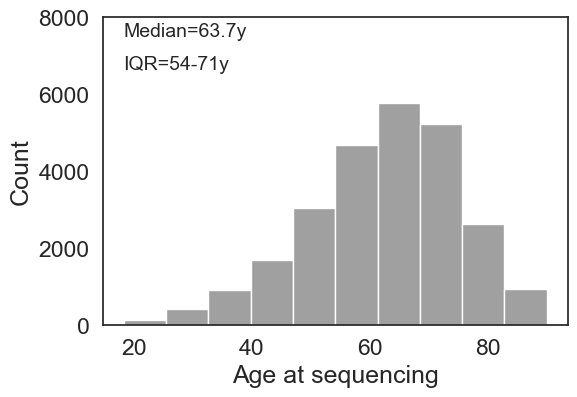

In [7]:
seq_age = quick_hist(raw_data_dict['data']['patient']['AGE_AT_SEQUENCING'],'y')

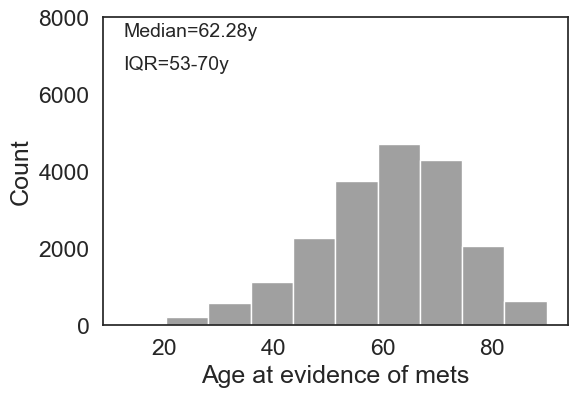

In [8]:
met_age = quick_hist(raw_data_dict['data']['patient']['AGE_AT_EVIDENCE_OF_METS'],'y')

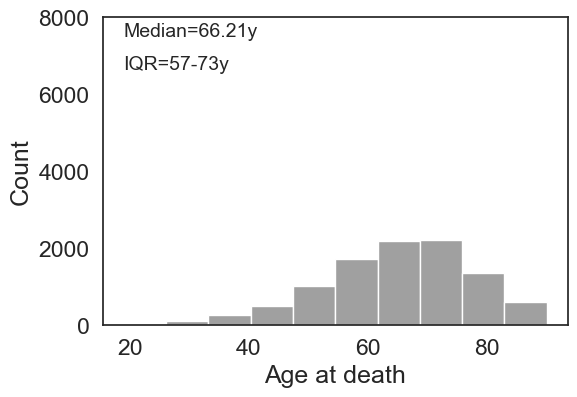

In [9]:
dec_age = quick_hist(raw_data_dict['data']['patient']['AGE_AT_DEATH'],'y')

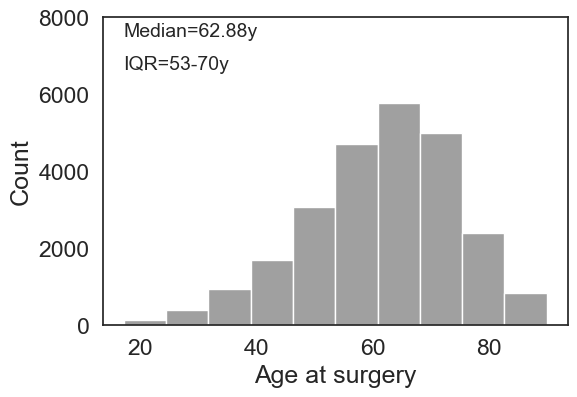

In [10]:
surg_age = quick_hist(raw_data_dict['data']['patient']['AGE_AT_SURGERY'],'y')

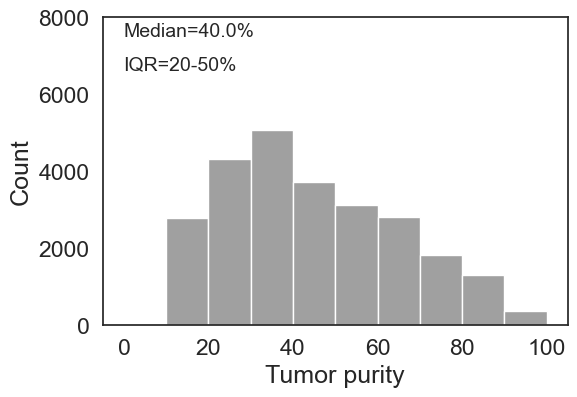

In [11]:
tumor_pur = quick_hist(raw_data_dict['data']['sample']['TUMOR_PURITY'],'%')

In [143]:
tidy = raw_data_dict['data']['sample'].groupby(['ORGAN_SYSTEM','SUBTYPE','SAMPLE_TYPE'])['SAMPLE_ID'] \
           .nunique() \
           .reset_index(level=[0,1,2])

grouped = tidy.groupby('ORGAN_SYSTEM')

calc_pri_met_dist('Breast')

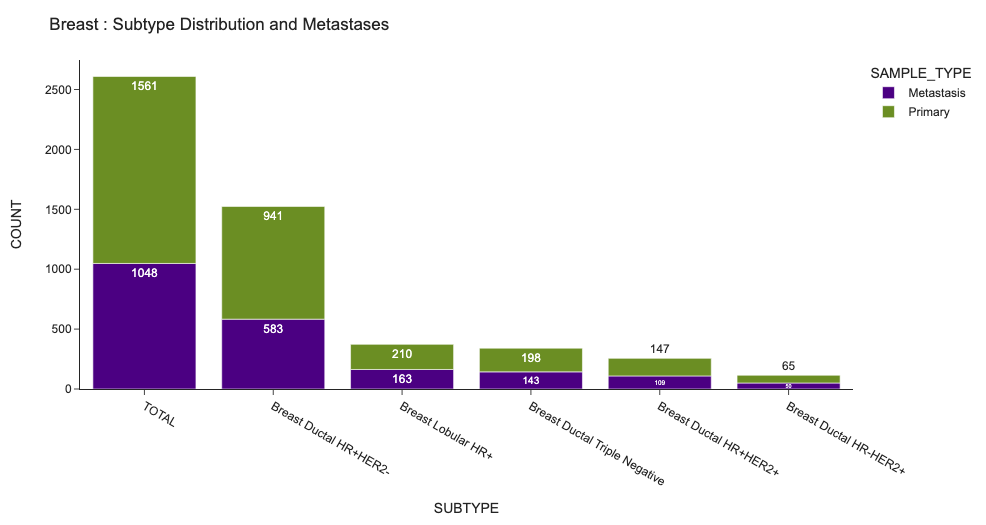

In [13]:
tmb_by_type = raw_data_dict['data']['sample']\
    .groupby(['ORGAN_SYSTEM','SAMPLE_TYPE']) \
    ['TMB_NONSYNONYMOUS'].agg(['mean','sem','median']) \
    .reset_index()

In [14]:
tmb_by_type.head()

,ORGAN_SYSTEM,SAMPLE_TYPE,mean,sem,median
0,Breast,Metastasis,5.385843,0.212881,3.914879
1,Breast,Primary,3.638400,0.255676,2.594094
2,Core GI,Metastasis,6.887967,0.254577,5.188189
3,Core GI,Primary,10.893728,0.401312,5.188189
4,Developmental GI Tract,Metastasis,4.717553,0.229472,3.914879


In [15]:
px.bar(data_frame=tmb_by_type,
       x='ORGAN_SYSTEM',
       y='mean',
       color='SAMPLE_TYPE',
       barmode='group',
       error_x='sem', 
       error_y='sem',
       color_discrete_sequence=['teal', 'palevioletred']).update_layout(
                        template='simple_white',
                        font_family='Arial',
                        title={
                                'text': 'Nonsynonomous Tumor Mutation Burden',
                              },
                        xaxis_title='Organ System', 
                        yaxis_title='Mean',
                    ) 

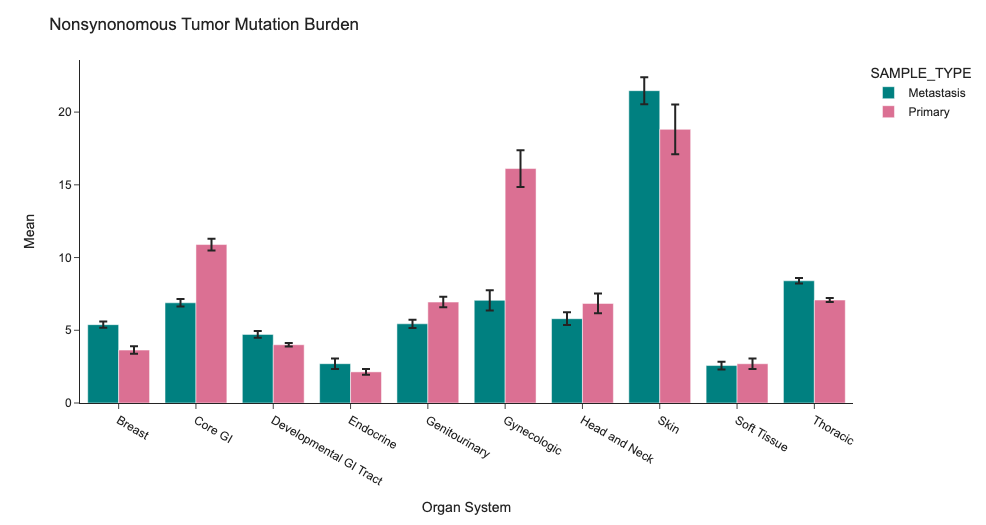

In [16]:
#same thing but now scatter plot
raw_data_dict['data']['sample'].head()

,SAMPLE_ID,PATIENT_ID,ORGAN_SYSTEM,ONCOTREE_CODE,SUBTYPE,SUBTYPE_ABBREVIATION,SAMPLE_TYPE,PRIMARY_SITE,METASTATIC_SITE,GENE_PANEL,...,DMETS_DX_ADRENAL_GLAND,DMETS_DX_KIDNEY,DMETS_DX_BLADDER_UT,DMETS_DX_FEMALE_GENITAL,DMETS_DX_OVARY,DMETS_DX_MALE_GENITAL,DMETS_DX_SKIN,DMETS_DX_HEAD_NECK,DMETS_DX_BREAST,TMB_NONSYNONYMOUS
0,P-0000004-T01-IM3,P-0000004,Breast,IDC,Breast Ductal HR+HER2-,IDC HR+HER2-,Primary,Breast,NaN,IMPACT341,...,No,No,No,No,No,No,No,No,No,4.436621
1,P-0000015-T01-IM3,P-0000015,Breast,IDC,Breast Ductal HR+HER2-,IDC HR+HER2-,Metastasis,Breast,Liver,IMPACT341,...,No,No,No,No,Yes,No,No,No,No,7.764087
2,P-0000024-T01-IM3,P-0000024,Gynecologic,UEC,Uterine Endometrioid,UCEC ENDO,Metastasis,Uterus,Lung,IMPACT341,...,No,No,No,No,No,No,No,No,No,6.654932
3,P-0000025-T02-IM5,P-0000025,Gynecologic,USC,Uterine Serous,UCEC SEROUS,Metastasis,Uterus,Intra-Abdominal,IMPACT410,...,Yes,No,No,Yes,Yes,No,No,No,No,1.957439
4,P-0000026-T01-IM3,P-0000026,Gynecologic,UEC,Uterine Endometrioid,UCEC ENDO,Metastasis,Uterus,Unspecified,IMPACT341,...,No,No,No,Yes,No,No,No,No,No,4.436621


In [139]:
met_sites = quick_pie_prep(raw_data_dict['data']['sample']['METASTATIC_SITE'])
px.pie(met_sites,
       names=met_sites['METASTATIC_SITE'],
       values=met_sites['Count'],
       hover_name=met_sites['annot'],
       color_discrete_sequence=px.colors.qualitative.Vivid).update_layout(template='simple_white',
                        font_family='Arial',
                        title={
                                'text': 'Metastatic Sites (MSK-MET)',
                              })

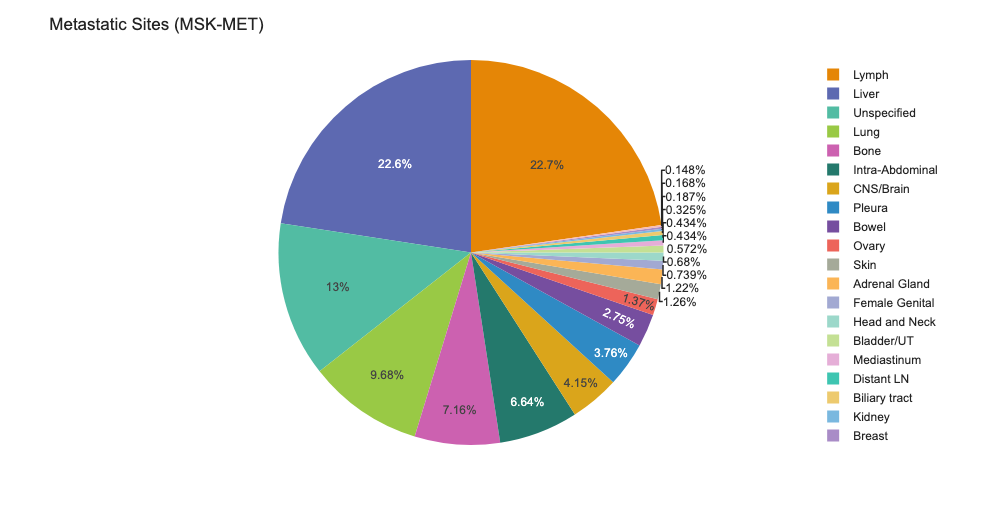

In [138]:
pri_sites = quick_pie_prep(raw_data_dict['data']['sample']['PRIMARY_SITE']).head(10)

px.pie(pri_sites,
       names=pri_sites['PRIMARY_SITE'],
       values=pri_sites['Count'],
       hover_name=pri_sites['annot'],
       color_discrete_sequence=px.colors.qualitative.Vivid).update_layout(template='simple_white',
                        font_family='Arial',
                        title={
                                'text': 'Top 10 Primary Sites (MSK-MET)',
                              })

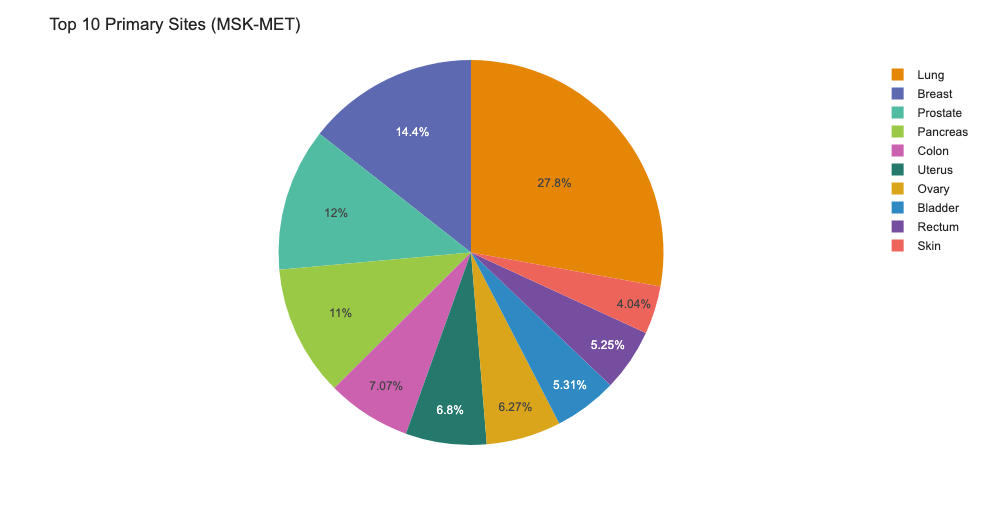

In [154]:
mets = raw_data_dict['data']['sample'] \
.query("SAMPLE_TYPE == 'Metastasis'") \
.groupby(['ORGAN_SYSTEM','SUBTYPE','PRIMARY_SITE','METASTATIC_SITE']) \
['PATIENT_ID'].count() \
.reset_index() \
.rename(columns={'PATIENT_ID': 'PATIENT_COUNT'})

In [164]:
a, b = show_met_dist(mets,'Breast')

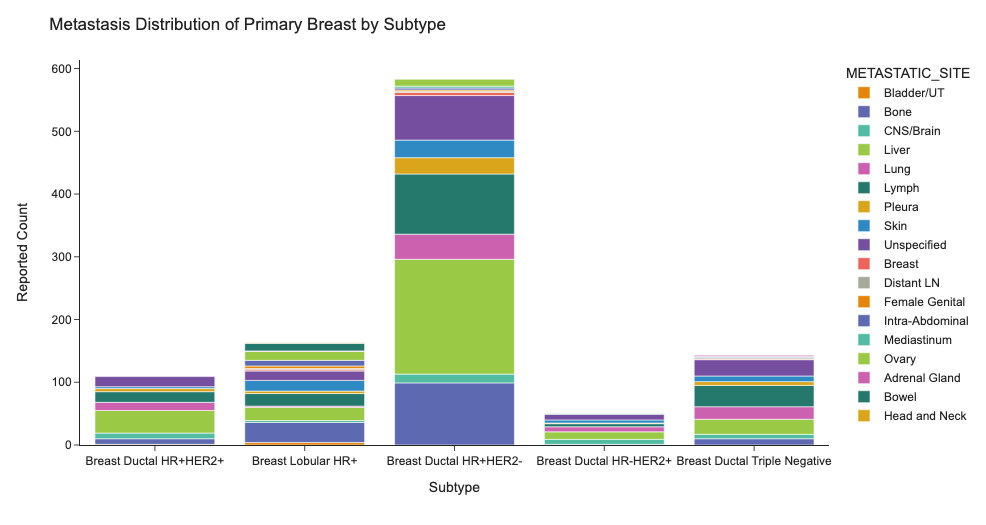

In [169]:
x = raw_data_dict['data']['sample'].loc[:,'DMETS_DX_ADRENAL_GLAND':'DMETS_DX_BREAST'].replace({'No': 0, 'Yes': 1})

<Axes: >

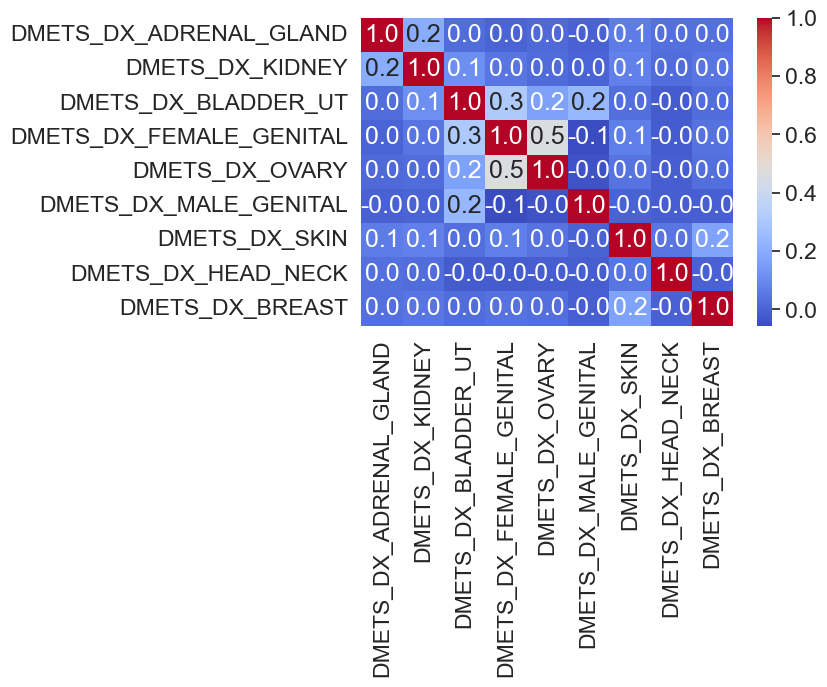

In [170]:
#not seeing a lot of correlation with these features so hard to make the decision now to drop any features
sns.heatmap(x.corr(), annot=True, fmt=".1f",cmap='coolwarm')